In [ ]:
!pip install -q gdown

import gdown, zipfile

file_id = "1t5YDg4_X97edTd0q-i82UdhapIgsM1pP"
url = f"https://drive.google.com/uc?id={file_id}"
output = "MergedYOLO.zip"

gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("merged_dataset")


Downloading...
From (original): https://drive.google.com/uc?id=1t5YDg4_X97edTd0q-i82UdhapIgsM1pP
From (redirected): https://drive.google.com/uc?id=1t5YDg4_X97edTd0q-i82UdhapIgsM1pP&confirm=t&uuid=12b4b1cc-dde4-4c5b-af7f-6d646b5c5b0d
To: /content/MergedYOLO.zip
100%|██████████| 1.13G/1.13G [01:04<00:00, 17.5MB/s]


Split Dataset and Copy to YOLO Directory Structure

In [2]:
from pathlib import Path
import os
from sklearn.model_selection import train_test_split

image_dir = Path("merged_dataset/images")
label_dir = Path("merged_dataset/labels")
all_imgs = sorted(image_dir.glob("*.jpg"))
all_lbls = [label_dir / f"{p.stem}.txt" for p in all_imgs]
paired_imgs = [img for img, lbl in zip(all_imgs, all_lbls) if lbl.exists()]
paired_lbls = [label_dir / f"{img.stem}.txt" for img in paired_imgs]


train_i, test_i = train_test_split(range(len(paired_imgs)), test_size=0.2, random_state=42)
train_imgs = [paired_imgs[i] for i in train_i]
train_lbls = [paired_lbls[i] for i in train_i]
test_imgs  = [paired_imgs[i] for i in test_i]
test_lbls  = [paired_lbls[i] for i in test_i]

for split in ["train", "val"]:
    os.makedirs(f"mobilevit_yolo/images/{split}", exist_ok=True)
    os.makedirs(f"mobilevit_yolo/labels/{split}", exist_ok=True)


for img, lbl in zip(train_imgs, train_lbls):
    os.system(f"cp '{img}' mobilevit_yolo/images/train/")
    os.system(f"cp '{lbl}' mobilevit_yolo/labels/train/")


for img, lbl in zip(test_imgs, test_lbls):
    os.system(f"cp '{img}' mobilevit_yolo/images/val/")
    os.system(f"cp '{lbl}' mobilevit_yolo/labels/val/")


In [3]:
yaml_content = """
path: mobilevit_yolo
train: images/train
val: images/val
nc: 3
names: ['fire', 'smoke', 'non-fire']
"""

with open("mobilevit_yolo/data.yaml", "w") as f:
    f.write(yaml_content)


Define YOLO + MobileViT Model Architecture (Backbone + Head)

In [4]:
model_yaml = """
# YOLO + MobileViT
backbone:
  [[-1, 1, Conv, [32, 3, 2]],
   [-1, 1, Conv, [64, 3, 2]],
   [-1, 1, Conv, [128, 3, 2]],
   [-1, 1, Conv, [256, 3, 2]],
   [-1, 1, MobileViT, [640]]]

head:
  [[-1, 1, Detect, [3, 3]]]
"""

with open("mobilevit_yolo/mobilevit_yolo.yaml", "w") as f:
    f.write(model_yaml)


In [6]:
!mkdir -p /content/datasets
!mv mobilevit_yolo /content/datasets/


In [7]:
import os

base_path = "/content/datasets/mobilevit_yolo"
yaml_content = f"""
path: {base_path}
train: {base_path}/images/train
val: {base_path}/images/val
nc: 3
names: ['fire', 'smoke', 'non-fire']
"""

with open(f"{base_path}/data.yaml", "w") as f:
    f.write(yaml_content)


In [9]:
!pip install -q timm ultralytics opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00


Load YOLOv8n Base Model and Start Training

In [11]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data="/content/datasets/mobilevit_yolo/data.yaml",
    epochs=20,
    imgsz=416,
    batch=8,
    name="yolo_mobilevit_fast3"
)


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/mobilevit_yolo/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_mobilevit_fast32, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

train: Scanning /content/datasets/mobilevit_yolo/labels/train.cache... 7200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7200/7200 [00:00<?, ?it/s]

train: /content/datasets/mobilevit_yolo/images/train/WEB07199.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07271.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07278.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07297.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07536.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07540.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07541.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07543.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07555.jpg: corrupt JPEG restored and saved
train: /content/datasets/mobilevit_yolo/images/train/WEB07556.jpg: corrupt JPEG restored and saved
train: /co

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 391.8±242.9 MB/s, size: 75.8 KB)


val: Scanning /content/datasets/mobilevit_yolo/labels/val.cache... 1799 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1800/1800 [00:00<?, ?it/s]

val: /content/datasets/mobilevit_yolo/images/val/WEB07305.jpg: corrupt JPEG restored and saved
val: /content/datasets/mobilevit_yolo/images/val/WEB07554.jpg: corrupt JPEG restored and saved
val: /content/datasets/mobilevit_yolo/images/val/nonfire_1335.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'jpg', 'dng', 'webp', 'heic', 'tif', 'jpeg', 'tiff', 'pfm', 'bmp', 'mpo', 'png'}
videos: {'mpg', 'gif', 'avi', 'mov', 'mpeg', 'webm', 'mp4', 'wmv', 'mkv', 'ts', 'asf', 'm4v'}


Plotting labels to runs/detect/yolo_mobilevit_fast32/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/yolo_mobilevit_fast32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.588G      1.079      1.698       1.27         22        416: 100%|██████████| 900/900 [02:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:15<00:00,  7.22it/s]


                   all       1799       3201      0.614       0.58      0.575      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.799G      1.072      1.359      1.247         32        416: 100%|██████████| 900/900 [01:59<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.46it/s]


                   all       1799       3201      0.604      0.592      0.601      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.799G      1.039      1.261      1.228         32        416: 100%|██████████| 900/900 [01:52<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.47it/s]


                   all       1799       3201      0.579      0.528      0.554       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.812G      1.012      1.197      1.211         44        416: 100%|██████████| 900/900 [01:55<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.53it/s]


                   all       1799       3201      0.667      0.626      0.647      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.824G     0.9693      1.143      1.192         29        416: 100%|██████████| 900/900 [01:51<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.49it/s]

                   all       1799       3201      0.668      0.635      0.656      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.824G     0.9668      1.105      1.184         33        416: 100%|██████████| 900/900 [01:51<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.19it/s]


                   all       1799       3201      0.685      0.659       0.69      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.824G     0.9403       1.06      1.174         29        416: 100%|██████████| 900/900 [01:52<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.20it/s]


                   all       1799       3201      0.657       0.65      0.679      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.824G     0.9312      1.042      1.169         31        416: 100%|██████████| 900/900 [01:52<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.47it/s]


                   all       1799       3201      0.711      0.672      0.699      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.824G     0.9061      1.001      1.152         30        416: 100%|██████████| 900/900 [01:51<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.45it/s]

                   all       1799       3201       0.73      0.676      0.712      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.824G     0.9008     0.9671      1.147         28        416: 100%|██████████| 900/900 [01:51<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.55it/s]

                   all       1799       3201      0.695      0.675       0.71      0.528


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.824G      1.035      1.014      1.216         16        416: 100%|██████████| 900/900 [01:45<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.72it/s]

                   all       1799       3201      0.712      0.675      0.702      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.824G      1.009     0.9335      1.195          9        416: 100%|██████████| 900/900 [01:43<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.76it/s]


                   all       1799       3201      0.762       0.67      0.724       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.824G      1.001      0.916      1.189          8        416: 100%|██████████| 900/900 [01:44<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.92it/s]

                   all       1799       3201      0.731      0.694      0.722      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      0.84G     0.9968     0.8815      1.181         13        416: 100%|██████████| 900/900 [01:43<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.77it/s]


                   all       1799       3201      0.754        0.7      0.737      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      0.84G      0.975     0.8569      1.173         14        416: 100%|██████████| 900/900 [01:43<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.72it/s]

                   all       1799       3201      0.751      0.725      0.754      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.857G     0.9616     0.8314      1.166         15        416: 100%|██████████| 900/900 [01:44<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.59it/s]


                   all       1799       3201      0.765      0.712      0.753      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.857G     0.9465     0.8002      1.152         13        416: 100%|██████████| 900/900 [01:44<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.40it/s]


                   all       1799       3201      0.775       0.73      0.769       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.857G     0.9273     0.7803      1.142         16        416: 100%|██████████| 900/900 [01:48<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:17<00:00,  6.43it/s]


                   all       1799       3201      0.785      0.736      0.774      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.857G     0.9171     0.7523      1.132         11        416: 100%|██████████| 900/900 [01:53<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.73it/s]


                   all       1799       3201      0.778      0.733      0.773      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.857G     0.9059     0.7294      1.125         14        416: 100%|██████████| 900/900 [01:48<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.80it/s]


                   all       1799       3201      0.786      0.743      0.782      0.585

20 epochs completed in 0.689 hours.
Optimizer stripped from runs/detect/yolo_mobilevit_fast32/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolo_mobilevit_fast32/weights/best.pt, 6.2MB

Validating runs/detect/yolo_mobilevit_fast32/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:13<00:00,  8.55it/s]


                   all       1799       3201      0.787      0.741      0.782      0.585
                  fire       1062       1190      0.747      0.693      0.754      0.449
                 smoke        576       1398      0.654      0.544      0.598      0.312
              non-fire        613        613       0.96      0.985      0.993      0.993
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/yolo_mobilevit_fast32


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dc5cc14cbd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [13]:
from google.colab import files
files.download("/content/runs/detect/yolo_mobilevit_fast32/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
from ultralytics import YOLO

model = YOLO("runs/detect/yolo_mobilevit_fast32/weights/best.pt")


Plot Training Loss and Accuracy Metrics

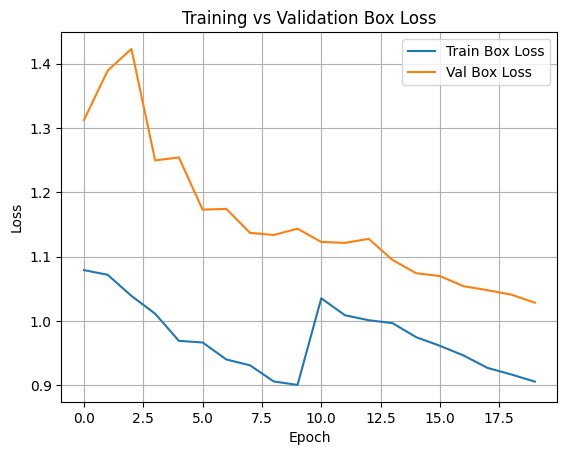

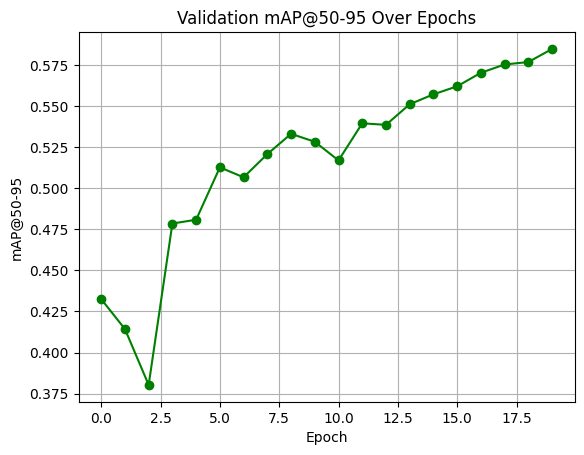

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/runs/detect/yolo_mobilevit_fast32/results.csv"
df = pd.read_csv(csv_path)
df.columns = [c.strip() for c in df.columns]
train_loss = df['train/box_loss'].tolist()
val_loss   = df['val/box_loss'].tolist()
map50_95   = df['metrics/mAP50-95(B)'].tolist()

plt.plot(train_loss, label="Train Box Loss")
plt.plot(val_loss, label="Val Box Loss")
plt.title("Training vs Validation Box Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(map50_95, marker='o', color='green')
plt.title("Validation mAP@50-95 Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@50-95")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import timm
import random

contrastive_transform = T.Compose([
    T.RandomResizedCrop(256),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor()
])


class UnlabeledImageDataset(Dataset):
    def __init__(self, folder, limit=1000):  
        all_images = [os.path.join(folder, f) for f in os.listdir(folder)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.image_paths = random.sample(all_images, min(limit, len(all_images)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return img

dataset_path = "/content/dataset/images/train"
contrastive_dataset = UnlabeledImageDataset(dataset_path, limit=1000)

def pil_collate(batch):
    return batch

contrastive_loader = DataLoader(
    contrastive_dataset, batch_size=32, shuffle=True, collate_fn=pil_collate
)

In [ ]:
mobilevit = timm.create_model("mobilevit_s.cvnets_in1k", pretrained=True, features_only=True)
for p in mobilevit.parameters():
    p.requires_grad = False
mobilevit = mobilevit.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

In [29]:
class MobileViTEncoder(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

    def forward(self, x):
        features = self.backbone(x)
        return torch.flatten(features[-1], start_dim=1)  # Use last stage output

encoder = MobileViTEncoder(mobilevit).to("cuda")


In [30]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, x):
        return self.net(x)

projector = ProjectionHead(in_dim=encoder(torch.randn(1, 3, 256, 256).to("cuda")).shape[1]).to("cuda")
optimizer = torch.optim.Adam(projector.parameters(), lr=3e-4)


Defining loss function

In [ ]:
def nt_xent_loss(z1, z2, temperature=0.5):
    z = torch.cat([z1, z2], dim=0)
    sim = nn.functional.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature
    N = z1.size(0)
    labels = torch.arange(N, device=z.device)
    labels = torch.cat([labels + N, labels], dim=0)
    sim_mask = torch.eye(2 * N, device=z.device) * 1e9
    sim = sim - sim_mask
    return nn.functional.cross_entropy(sim, labels)


SimCLR Training Loop using MobileViT Encoder

In [32]:
temperature = 0.5
contrastive_losses = []

for epoch in range(20):
    total_loss = 0
    for batch in contrastive_loader:
        x1 = torch.stack([contrastive_transform(img) for img in batch]).to("cuda")
        x2 = torch.stack([contrastive_transform(img) for img in batch]).to("cuda")

        with torch.no_grad():
            h1 = encoder(x1)
            h2 = encoder(x2)

        z1 = projector(h1)
        z2 = projector(h2)

        loss = nt_xent_loss(z1, z2, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(contrastive_loader)
    contrastive_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Contrastive Loss: {avg_loss:.4f}")


Epoch 1 | Contrastive Loss: 3.4086
Epoch 2 | Contrastive Loss: 3.0833
Epoch 3 | Contrastive Loss: 2.9760
Epoch 4 | Contrastive Loss: 2.9345
Epoch 5 | Contrastive Loss: 2.9269
Epoch 6 | Contrastive Loss: 2.8662
Epoch 7 | Contrastive Loss: 2.8703
Epoch 8 | Contrastive Loss: 2.8736
Epoch 9 | Contrastive Loss: 2.8320
Epoch 10 | Contrastive Loss: 2.8191
Epoch 11 | Contrastive Loss: 2.8116
Epoch 12 | Contrastive Loss: 2.7828
Epoch 13 | Contrastive Loss: 2.7951
Epoch 14 | Contrastive Loss: 2.7951
Epoch 15 | Contrastive Loss: 2.7910
Epoch 16 | Contrastive Loss: 2.7595
Epoch 17 | Contrastive Loss: 2.7498
Epoch 18 | Contrastive Loss: 2.7467
Epoch 19 | Contrastive Loss: 2.7463
Epoch 20 | Contrastive Loss: 2.7535


Plot Contrastive Loss Curve and Save Projection Head

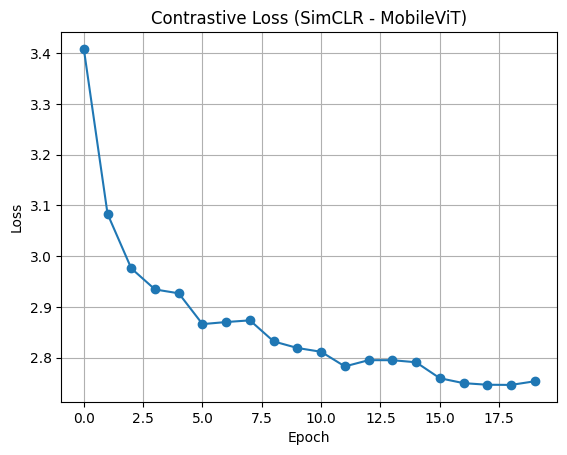

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(contrastive_losses, marker='o')
plt.title("Contrastive Loss (SimCLR - MobileViT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

proj_path = "/content/projection_head_mobilevit_contrastive.pt"
torch.save(projector.state_dict(), proj_path)

from google.colab import files
files.download(proj_path)


In [ ]:
from google.colab import files

files.download("/content/runs/detect/yolo_mobilevit_fast32/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load Final YOLO Model and Evaluate

In [ ]:
from ultralytics import YOLO
import os

if os.path.exists("best (4).pt"):
    os.rename("best (4).pt", "yolo_mobilevit_final.pt")

model_C = YOLO("yolo_mobilevit_final.pt")
print("Loaded YOLO model with MobileViT backbone.")

results_C = model_C.val(device="cpu")

map_50_95 = results_C.results_dict.get("metrics/mAP50-95", None)
if map_50_95 is not None:
    print(f"\nmAP@50-95 (MobileViT YOLO): {map_50_95:.4f}")
else:
    print("mAP@50-95 metric not found in results.")


Loaded YOLO model with MobileViT backbone.
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2124.9±1141.6 MB/s, size: 194.4 KB)


val: Scanning /content/datasets/mobilevit_yolo/labels/val.cache... 1799 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1800/1800 [00:00<?, ?it/s]

val: /content/datasets/mobilevit_yolo/images/val/WEB07305.jpg: corrupt JPEG restored and saved
val: /content/datasets/mobilevit_yolo/images/val/WEB07554.jpg: corrupt JPEG restored and saved
val: /content/datasets/mobilevit_yolo/images/val/nonfire_1335.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'jpg', 'dng', 'webp', 'heic', 'tif', 'jpeg', 'tiff', 'pfm', 'bmp', 'mpo', 'png'}
videos: {'mpg', 'gif', 'avi', 'mov', 'mpeg', 'webm', 'mp4', 'wmv', 'mkv', 'ts', 'asf', 'm4v'}



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [02:14<00:00,  1.19s/it]


                   all       1799       3201      0.786      0.743      0.782      0.585
                  fire       1062       1190      0.747      0.697      0.754      0.448
                 smoke        576       1398      0.652      0.548      0.599      0.312
              non-fire        613        613      0.959      0.985      0.993      0.993
Speed: 0.7ms preprocess, 67.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val
mAP@50-95 metric not found in results.


Freeze MobileViT Backbone Weights for Fine-Tuning

In [43]:
mobilevit_backbone = model_C.model.model[0]
for param in mobilevit_backbone.parameters():
    param.requires_grad = False
print("MobileViT backbone frozen.")


MobileViT backbone frozen.


In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=40960, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, x):
        return self.net(x)

proj = ProjectionHead().to(device)
proj.load_state_dict(torch.load("/content/projection_head_mobilevit_contrastive.pt"))
proj.eval()
print("Loaded and frozen contrastive-trained projection head.")


Loaded and frozen contrastive-trained projection head.


In [ ]:
from ultralytics import YOLO
import torch

model_C = YOLO("/content/yolo_mobilevit_final.pt")

for name, param in model_C.model.named_parameters():
    if "model.0" in name:  
        param.requires_grad = False
    else:  
        param.requires_grad = True

print("Backbone frozen, YOLO head trainable.")


Backbone frozen, YOLO head trainable.


Stage C: Train Only YOLO Head with Frozen MobileViT Backbone

In [54]:
results_C = model_C.train(
    data="/content/fire_smoke.yaml",
    imgsz=224,
    epochs=20,
    batch=8,
    lr0=1e-3,
    device=device,
    project="runs/detect",
    name="StageC_FrozenMobileViT_Contrastive",
    verbose=True
)


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/fire_smoke.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/yolo_mobilevit_final.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=StageC_FrozenMobileViT_Contrastive, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

train: Scanning /content/dataset/labels/train... 7200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7200/7200 [00:03<00:00, 2196.90it/s]

train: /content/dataset/images/train/WEB07199.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07297.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07305.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07536.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07540.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07541.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07543.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07554.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07555.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07556.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07559.jpg: corrupt JPEG restored and saved
train: /content/dataset/images/train/WEB07561.jpg: corrupt JPEG restored and saved


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 395.3±164.3 MB/s, size: 67.1 KB)


val: Scanning /content/dataset/labels/val... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 1591.04it/s]

val: /content/dataset/images/val/WEB07271.jpg: corrupt JPEG restored and saved
val: /content/dataset/images/val/WEB07278.jpg: corrupt JPEG restored and saved
val: /content/dataset/images/val/WEB07557.jpg: corrupt JPEG restored and saved
val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/StageC_FrozenMobileViT_Contrastive/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/StageC_FrozenMobileViT_Contrastive
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.84G     0.9969      1.232      1.161         47        224: 100%|██████████| 900/900 [01:41<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.81it/s]


                   all        900       1644      0.688      0.685      0.684      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.84G     0.9193     0.9782      1.114         33        224: 100%|██████████| 900/900 [01:36<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.35it/s]


                   all        900       1644      0.656      0.639      0.666      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.86G       0.91     0.9732      1.107         25        224: 100%|██████████| 900/900 [01:37<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.28it/s]

                   all        900       1644      0.706      0.659       0.68      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.88G     0.8969      0.955      1.105         42        224: 100%|██████████| 900/900 [01:41<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.53it/s]

                   all        900       1644      0.669      0.647       0.67      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       1.9G     0.8858     0.9392      1.102         37        224: 100%|██████████| 900/900 [01:34<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.26it/s]

                   all        900       1644      0.654      0.659      0.663      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.91G     0.8624     0.9125      1.091         29        224: 100%|██████████| 900/900 [01:39<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.49it/s]


                   all        900       1644        0.7      0.679      0.696      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.93G      0.858     0.8915      1.086         29        224: 100%|██████████| 900/900 [01:34<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.77it/s]

                   all        900       1644      0.592      0.647      0.659       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.95G     0.8504     0.8802      1.087         25        224: 100%|██████████| 900/900 [01:34<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.40it/s]

                   all        900       1644      0.694      0.645      0.681       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.96G     0.8274     0.8523      1.078         24        224: 100%|██████████| 900/900 [01:35<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.01it/s]


                   all        900       1644      0.642      0.646      0.675      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.98G     0.8245     0.8374      1.073         22        224: 100%|██████████| 900/900 [01:35<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.26it/s]

                   all        900       1644      0.615      0.633      0.662      0.462


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         2G     0.9305     0.8176      1.102         17        224: 100%|██████████| 900/900 [01:32<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.34it/s]

                   all        900       1644      0.673      0.664      0.682      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.01G     0.9154     0.7768      1.092         11        224: 100%|██████████| 900/900 [01:30<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.32it/s]


                   all        900       1644      0.704      0.669      0.685      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.03G     0.8936     0.7596       1.08          8        224: 100%|██████████| 900/900 [01:31<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.39it/s]

                   all        900       1644      0.732      0.677      0.705      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.05G     0.8865     0.7256      1.074         13        224: 100%|██████████| 900/900 [01:31<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.20it/s]

                   all        900       1644      0.747      0.699      0.715      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.06G     0.8761      0.695      1.072         13        224: 100%|██████████| 900/900 [01:32<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.29it/s]

                   all        900       1644      0.738      0.697      0.717      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.08G      0.863     0.6825      1.063         16        224: 100%|██████████| 900/900 [01:32<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.76it/s]


                   all        900       1644      0.757      0.692      0.722      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.1G     0.8493     0.6675      1.056         14        224: 100%|██████████| 900/900 [01:31<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.44it/s]

                   all        900       1644      0.732      0.697      0.721      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.12G     0.8456     0.6556      1.054         16        224: 100%|██████████| 900/900 [01:33<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.95it/s]


                   all        900       1644      0.737      0.699      0.721      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.13G     0.8349     0.6317      1.048          8        224: 100%|██████████| 900/900 [01:32<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  9.15it/s]

                   all        900       1644      0.769      0.697       0.73      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.15G      0.822     0.6167      1.043         15        224: 100%|██████████| 900/900 [01:33<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:05<00:00, 10.29it/s]

                   all        900       1644       0.76      0.707      0.733      0.558



20 epochs completed in 0.562 hours.
Optimizer stripped from runs/detect/StageC_FrozenMobileViT_Contrastive/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/StageC_FrozenMobileViT_Contrastive/weights/best.pt, 6.2MB

Validating runs/detect/StageC_FrozenMobileViT_Contrastive/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:06<00:00,  8.23it/s]


                   all        900       1644      0.761      0.707      0.733      0.558
                  fire        528        571      0.736      0.699      0.748      0.465
                 smoke        309        767      0.615      0.428      0.456      0.214
               nonfire        306        306      0.931      0.993      0.994      0.994
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/StageC_FrozenMobileViT_Contrastive


Save Stage C Model and Report Final mAP

In [ ]:

mAP_C = results_C.results_dict["metrics/mAP50-95(B)"]
print(f"\nStage C complete — mAP@50‑95: {mAP_C:.4f}")

final_model_path = "runs/detect/StageC_FrozenMobileViT_Contrastive/weights/best.pt"
save_path_C = "/content/yolo_mobilevit_stageC_final.pt"

import shutil
shutil.copy(final_model_path, save_path_C)
print(f"Stage C model saved to: {save_path_C}")

from google.colab import files
files.download(save_path_C)



Stage C complete — mAP@50‑95: 0.5579
Stage C model saved to: /content/yolo_mobilevit_stageC_final.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/mobilevit_yolo.pt")

results = model.val(
    data="/content/fire_smoke.yaml",
    imgsz=224,
    batch=8,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print("mAP@50-95:", results.results_dict["metrics/mAP50-95(B)"])


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 874.0±309.9 MB/s, size: 49.1 KB)


val: Scanning /content/dataset/labels/val.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

val: /content/dataset/images/val/WEB07271.jpg: corrupt JPEG restored and saved
val: /content/dataset/images/val/WEB07278.jpg: corrupt JPEG restored and saved
val: /content/dataset/images/val/WEB07557.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:07<00:00, 15.64it/s]


                   all        900       1644      0.765      0.688      0.723      0.552
                  fire        528        571      0.736      0.673      0.727      0.455
                 smoke        309        767      0.613      0.402      0.448      0.208
              non-fire        306        306      0.945       0.99      0.993      0.993
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val2
mAP@50-95: 0.5522049965462391


Compare Baseline YOLO vs MobileViT Contrastive Fine-Tuned

In [ ]:
baseline_model = YOLO("/content/bestyolo.pt")
baseline_results = baseline_model.val(
    data="/content/fire_smoke.yaml",
    imgsz=160,
    batch=4,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

baseline_map = baseline_results.results_dict["metrics/mAP50-95(B)"]

mobilevit_map = map50_95[-1]

improvement = mobilevit_map - baseline_map
print("\nAccuracy Improvement Summary (YOLO ➝ SwinV2):")
print(f"Baseline YOLO mAP@50-95    : {baseline_map:.4f}")
print(f"Mobilevit Fine-Tuned mAP@50-95: {mobilevit_map:.4f}")
print(f"Improvement              : {improvement:.4f}")


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1764.1±594.7 MB/s, size: 153.6 KB)


val: Scanning /content/dataset/labels/val.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

val: /content/dataset/images/val/WEB07271.jpg: corrupt JPEG restored and saved
val: /content/dataset/images/val/WEB07278.jpg: corrupt JPEG restored and saved
val: /content/dataset/images/val/WEB07557.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:08<00:00, 27.82it/s]


                   all        900       1644      0.674      0.558      0.608      0.464
                  fire        528        571      0.594      0.567      0.562      0.308
                 smoke        309        767      0.455      0.313      0.298       0.12
              non fire        306        306      0.972      0.793      0.964      0.964
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val3

Accuracy Improvement Summary (YOLO ➝ SwinV2):
Baseline YOLO mAP@50-95    : 0.4638
Mobilevit Fine-Tuned mAP@50-95: 0.5848
Improvement              : 0.1210


Compare Stage A vs Stage C (Vanilla MobileViT vs Contrastive-Finetuned)

In [ ]:

map_stage_a = 0.4638  

map_stage_c = mAP_C

acc_improvement = map_stage_c - map_stage_a

print("\nAccuracy Improvement Summary (Stage A ➝ Stage C):")
print(f"MobileViT YOLO (Stage B) mAP@50-95     : {map_stage_a:.4f}")
print(f"Contrastive YOLO (Stage C) mAP@50-95   : {map_stage_c:.4f}")
print(f"Improvement                           : {acc_improvement:.4f}")



Accuracy Improvement Summary (Stage A ➝ Stage C):
MobileViT YOLO (Stage B) mAP@50-95     : 0.4638
Contrastive YOLO (Stage C) mAP@50-95   : 0.5579
Improvement                           : 0.0941


Final Inference Demo Using Trained Stage C Model


image 1/1 /content/dataset/images/test/nonfire_2718.jpg: 224x224 1 nonfire, 6.7ms
Speed: 0.7ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 224)


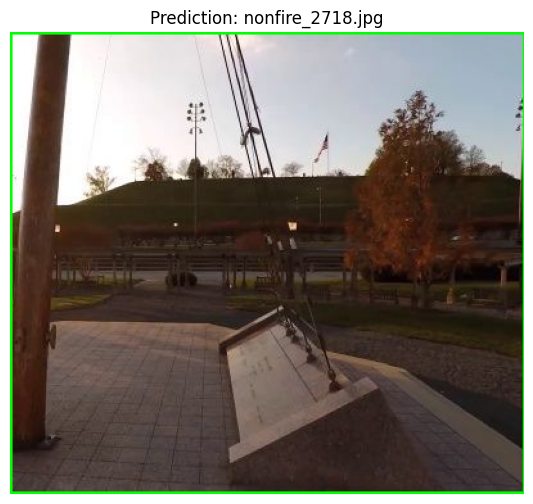

In [ ]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_img_dir = "/content/dataset/images/test"
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

img_path = random.choice(test_images)
result = model(img_path)[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    label = model.names[cls]
    text = f"{label} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Prediction: {os.path.basename(img_path)}")
plt.axis("off")
plt.show()



image 1/1 /content/dataset/images/test/AoF04839.jpg: 128x224 1 fire, 1 smoke, 8.8ms
Speed: 0.7ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 128, 224)


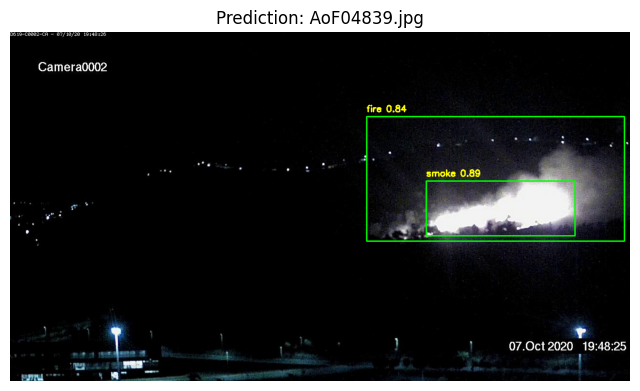

In [ ]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_img_dir = "/content/dataset/images/test"
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

img_path = random.choice(test_images)
result = model(img_path)[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    label = model.names[cls]
    text = f"{label} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Prediction: {os.path.basename(img_path)}")
plt.axis("off")
plt.show()



image 1/1 /content/dataset/images/test/WEB07183.jpg: 160x224 1 fire, 32.7ms
Speed: 0.6ms preprocess, 32.7ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 224)


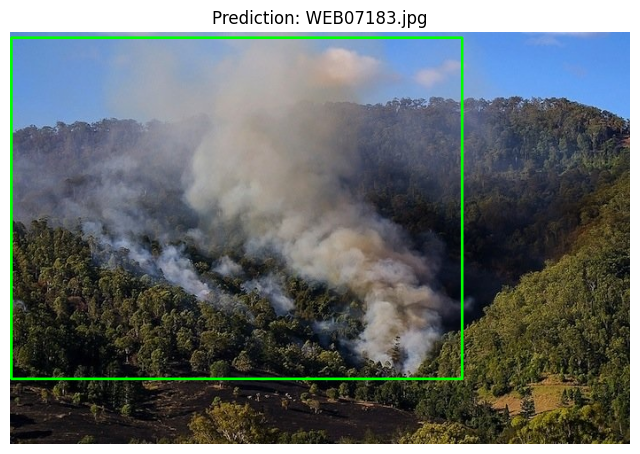

In [ ]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_img_dir = "/content/dataset/images/test"
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

img_path = random.choice(test_images)
result = model(img_path)[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    label = model.names[cls]
    text = f"{label} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Prediction: {os.path.basename(img_path)}")
plt.axis("off")
plt.show()



image 1/1 /content/dataset/images/test/WEB04961.jpg: 128x224 1 fire, 3 smokes, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 224)


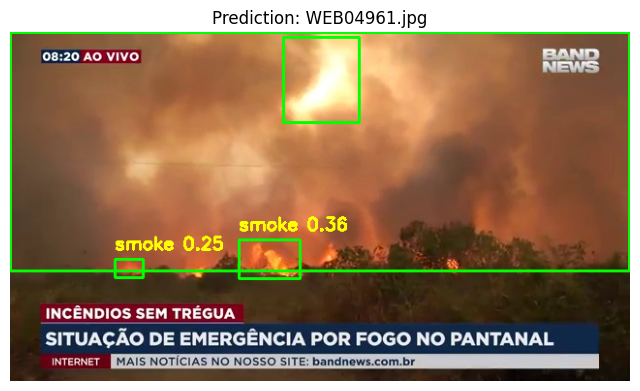

In [ ]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_img_dir = "/content/dataset/images/test"
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

img_path = random.choice(test_images)
result = model(img_path)[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    label = model.names[cls]
    text = f"{label} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Prediction: {os.path.basename(img_path)}")
plt.axis("off")
plt.show()



image 1/1 /content/dataset/images/test/AoF04873.jpg: 128x224 1 fire, 6 smokes, 6.9ms
Speed: 0.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 224)


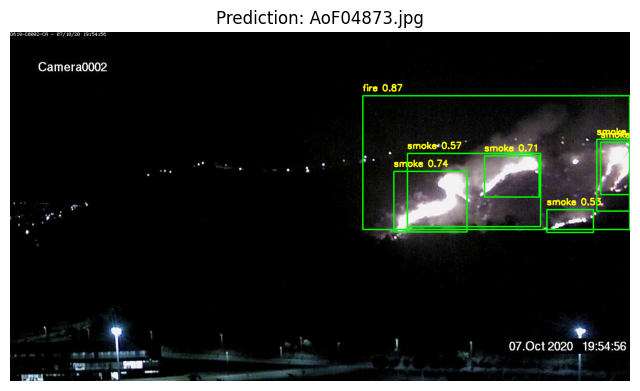

In [ ]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_img_dir = "/content/dataset/images/test"
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

img_path = random.choice(test_images)
result = model(img_path)[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    label = model.names[cls]
    text = f"{label} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Prediction: {os.path.basename(img_path)}")
plt.axis("off")
plt.show()



image 1/1 /content/dataset/images/test/AoF04569.jpg: 160x224 2 smokes, 8.5ms
Speed: 0.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 160, 224)


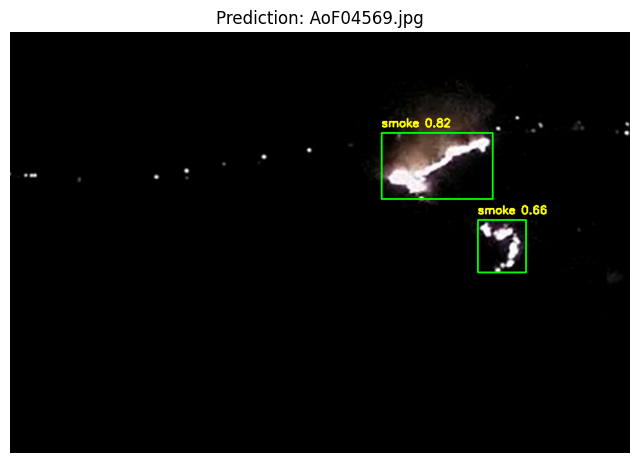

In [ ]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_img_dir = "/content/dataset/images/test"
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

img_path = random.choice(test_images)
result = model(img_path)[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    label = model.names[cls]
    text = f"{label} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Prediction: {os.path.basename(img_path)}")
plt.axis("off")
plt.show()



image 1/1 /content/dataset/images/test/WEB04777.jpg: 128x224 1 fire, 3 smokes, 7.1ms
Speed: 0.5ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 224)


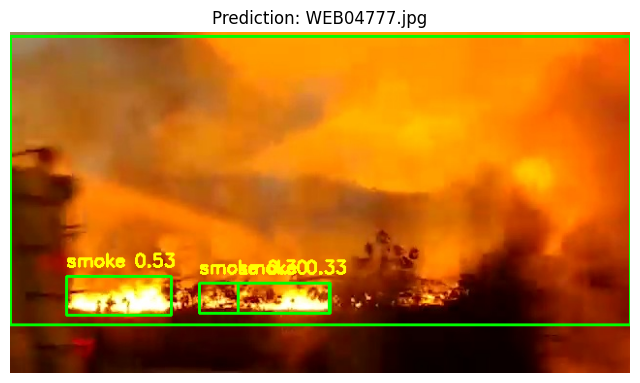

In [ ]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_img_dir = "/content/dataset/images/test"
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

img_path = random.choice(test_images)
result = model(img_path)[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    label = model.names[cls]
    text = f"{label} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Prediction: {os.path.basename(img_path)}")
plt.axis("off")
plt.show()


Visualize Bounding Boxes and Generate Confidence Heatmap (YOLO-MobileViT)

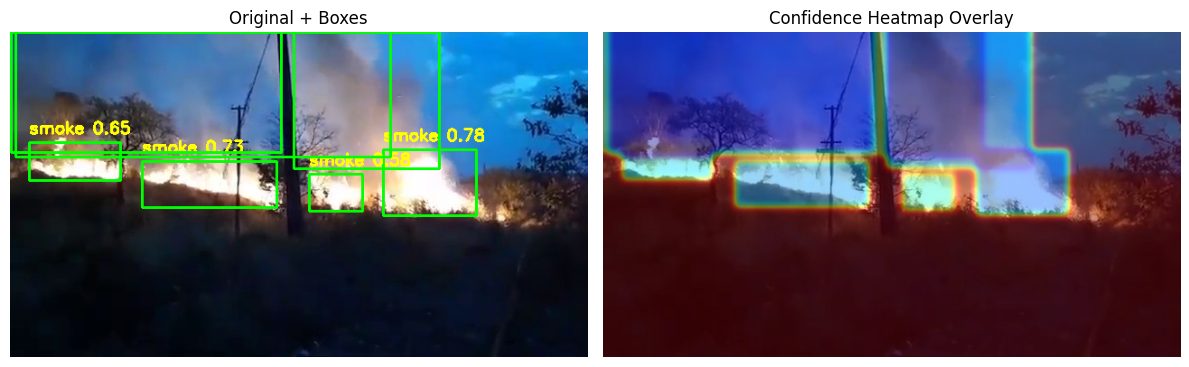

In [ ]:
import torch
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_dir = "/content/dataset/images/test"
test_imgs = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith((".jpg", ".png"))]
img_path = random.choice(test_imgs)

results = model(img_path, verbose=False)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

heatmap = np.zeros((h, w), dtype=np.float32)

for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    score = float(box.conf[0])
    heatmap[y1:y2, x1:x2] += score

heatmap = np.clip(heatmap, 0, 1)
heatmap = cv2.GaussianBlur(heatmap, (25, 25), 0)

heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap_overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original + Boxes")
plt.axis("off")
for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = int(box.cls[0].item())
    conf = float(box.conf[0])
    label = f"{model.names[cls]} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(heatmap_overlay)
plt.title("Confidence Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


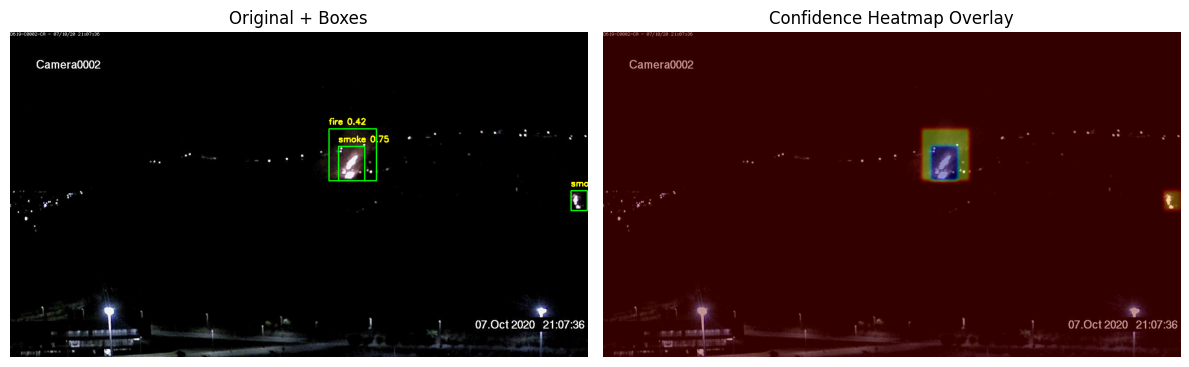

In [ ]:
import torch
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_dir = "/content/dataset/images/test"
test_imgs = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith((".jpg", ".png"))]
img_path = random.choice(test_imgs)

results = model(img_path, verbose=False)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

heatmap = np.zeros((h, w), dtype=np.float32)

for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    score = float(box.conf[0])
    heatmap[y1:y2, x1:x2] += score

heatmap = np.clip(heatmap, 0, 1)
heatmap = cv2.GaussianBlur(heatmap, (25, 25), 0)

heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap_overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original + Boxes")
plt.axis("off")
for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = int(box.cls[0].item())
    conf = float(box.conf[0])
    label = f"{model.names[cls]} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(heatmap_overlay)
plt.title("Confidence Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


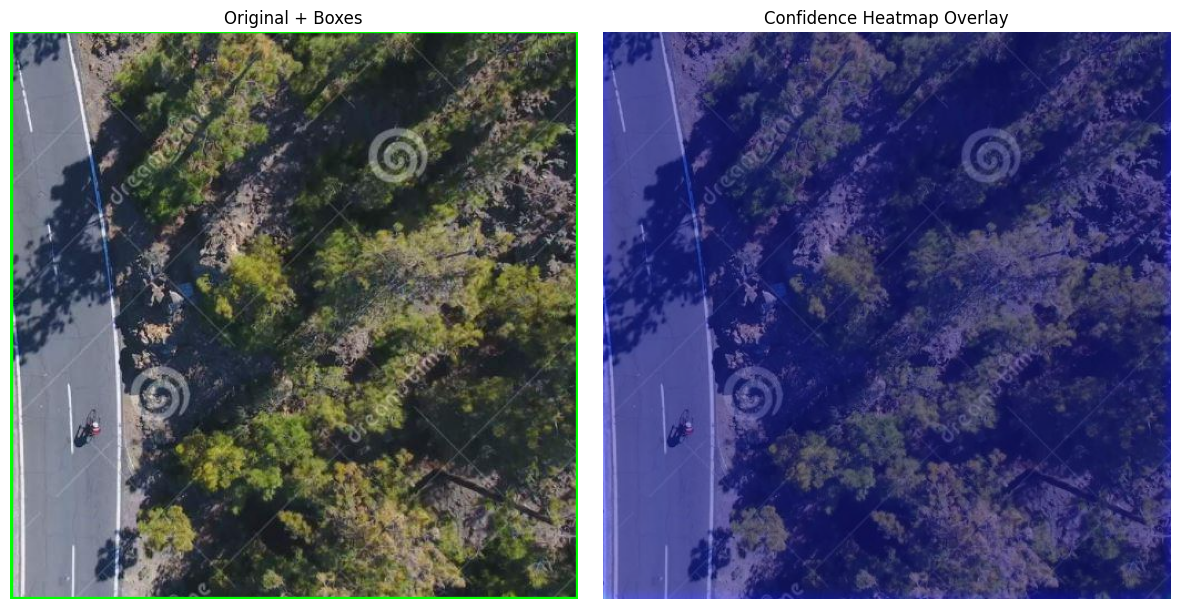

In [ ]:
import torch
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_dir = "/content/dataset/images/test"
test_imgs = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith((".jpg", ".png"))]
img_path = random.choice(test_imgs)

results = model(img_path, verbose=False)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

heatmap = np.zeros((h, w), dtype=np.float32)

for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    score = float(box.conf[0])
    heatmap[y1:y2, x1:x2] += score

heatmap = np.clip(heatmap, 0, 1)
heatmap = cv2.GaussianBlur(heatmap, (25, 25), 0)

heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap_overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original + Boxes")
plt.axis("off")
for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = int(box.cls[0].item())
    conf = float(box.conf[0])
    label = f"{model.names[cls]} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(heatmap_overlay)
plt.title("Confidence Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


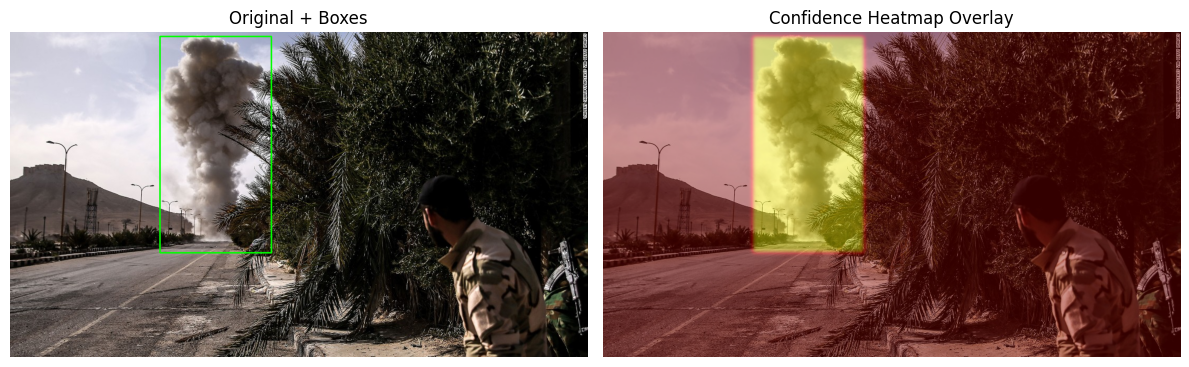

In [ ]:
import torch
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_dir = "/content/dataset/images/test"
test_imgs = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith((".jpg", ".png"))]
img_path = random.choice(test_imgs)

results = model(img_path, verbose=False)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

heatmap = np.zeros((h, w), dtype=np.float32)

for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    score = float(box.conf[0])
    heatmap[y1:y2, x1:x2] += score

heatmap = np.clip(heatmap, 0, 1)
heatmap = cv2.GaussianBlur(heatmap, (25, 25), 0)

heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap_overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original + Boxes")
plt.axis("off")
for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = int(box.cls[0].item())
    conf = float(box.conf[0])
    label = f"{model.names[cls]} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(heatmap_overlay)
plt.title("Confidence Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


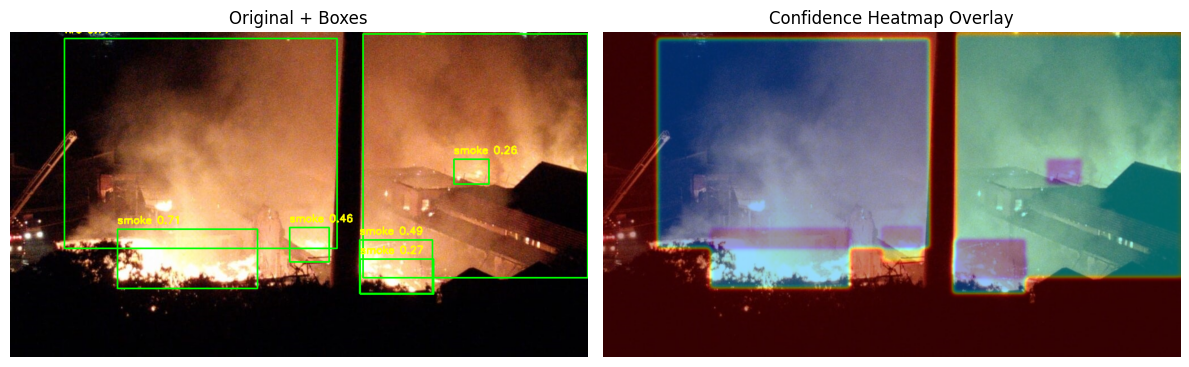

In [ ]:
import torch
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

model = YOLO("/content/yolo_mobilevit_stageC_final.pt")

test_dir = "/content/dataset/images/test"
test_imgs = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith((".jpg", ".png"))]
img_path = random.choice(test_imgs)

results = model(img_path, verbose=False)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

heatmap = np.zeros((h, w), dtype=np.float32)

for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    score = float(box.conf[0])
    heatmap[y1:y2, x1:x2] += score

heatmap = np.clip(heatmap, 0, 1)
heatmap = cv2.GaussianBlur(heatmap, (25, 25), 0)

heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap_overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original + Boxes")
plt.axis("off")
for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = int(box.cls[0].item())
    conf = float(box.conf[0])
    label = f"{model.names[cls]} {conf:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(heatmap_overlay)
plt.title("Confidence Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


Generate BLIP Captions for First 20 Test Images

🖼️ Displaying Images with BLIP Captions (First 20):


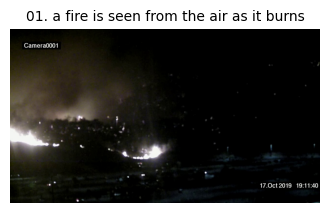

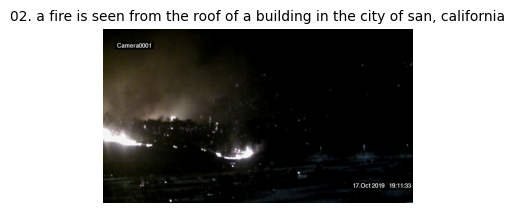

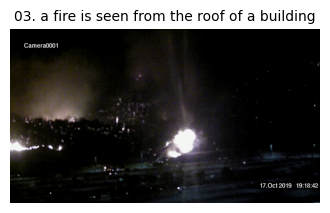

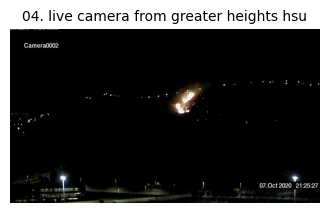

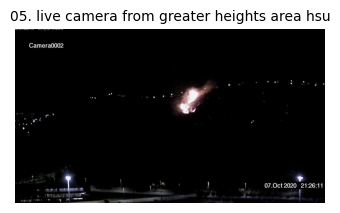

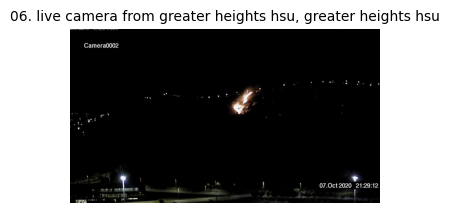

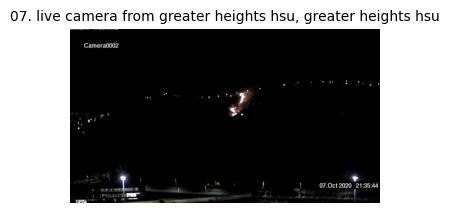

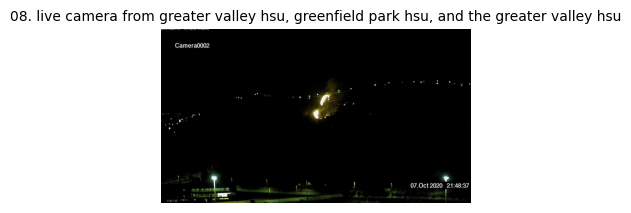

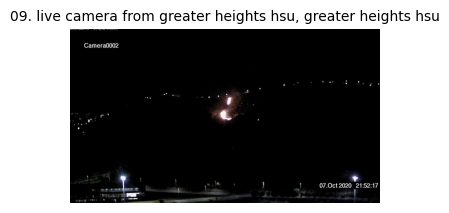

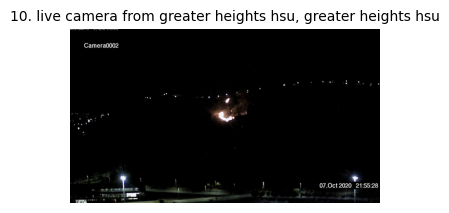

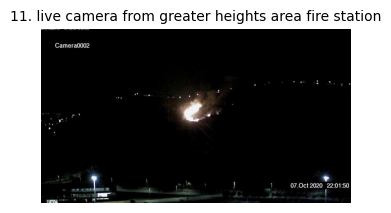

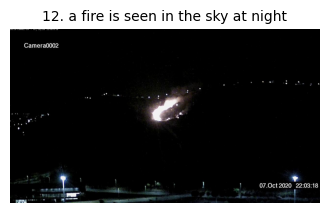

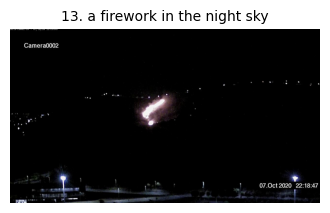

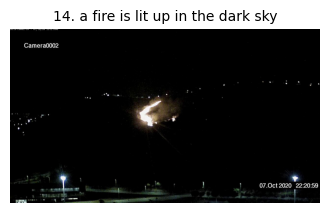

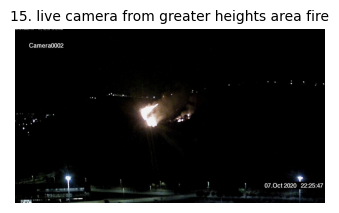

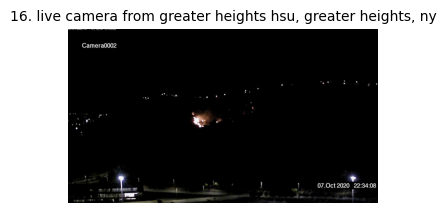

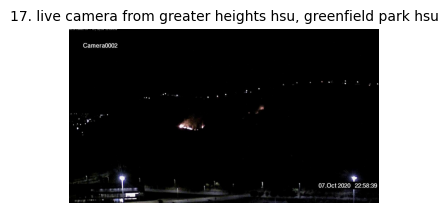

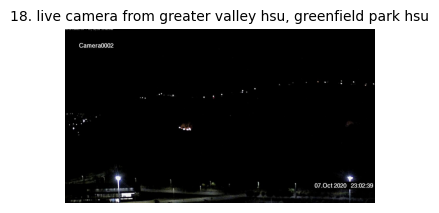

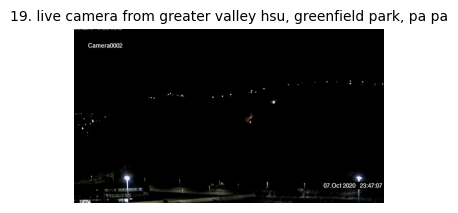

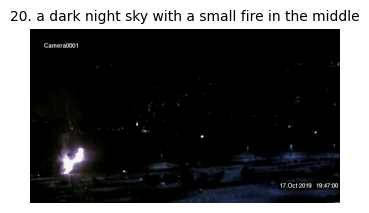

In [ ]:
!pip install -q transformers timm

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch, os
from glob import glob
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

test_dir = "/content/dataset/images/test"
test_images = sorted(glob(f"{test_dir}/*.jpg"))

captions = {}

for img_path in test_images[:20]:
    raw_image = Image.open(img_path).convert('RGB')
    inputs = processor(raw_image, return_tensors="pt").to(device)
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    captions[os.path.basename(img_path)] = caption

print("Displaying Images with BLIP Captions (First 20):")

for i, (img_name, caption) in enumerate(captions.items(), start=1):
    full_path = os.path.join(test_dir, img_name)
    image = Image.open(full_path).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{i:02d}. {caption}", fontsize=10)
    plt.show()


Run CLIP Predictions on First 20 Test Images

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 42.1MiB/s]


Displaying Images with CLIP Predictions (First 20):


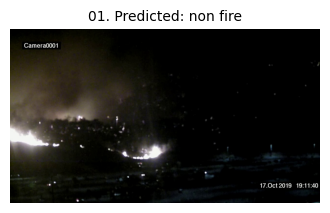

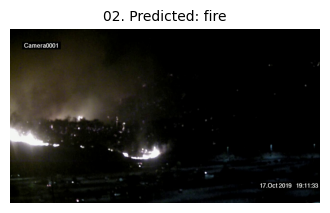

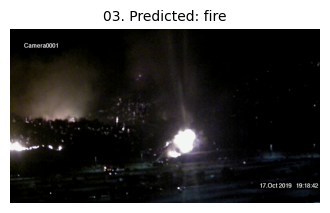

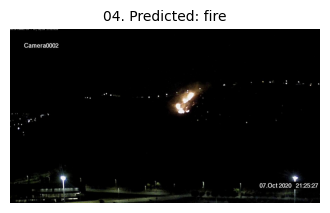

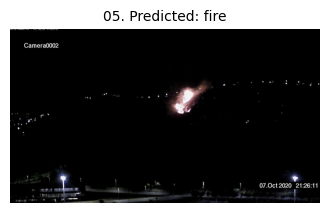

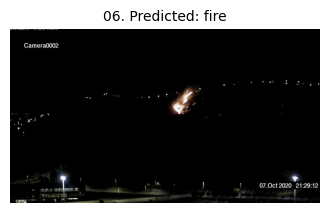

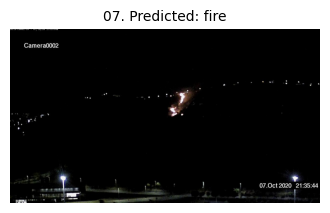

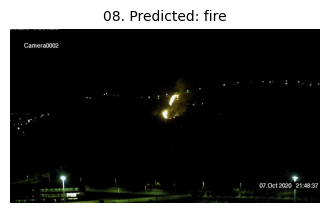

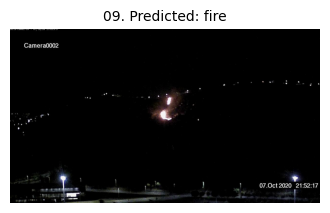

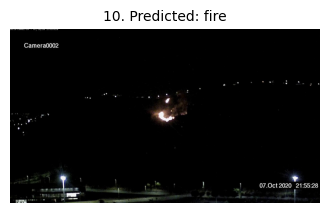

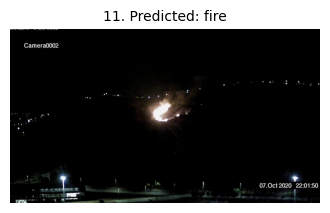

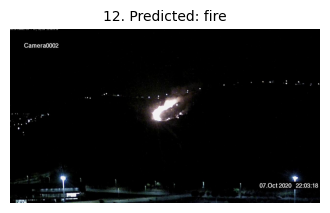

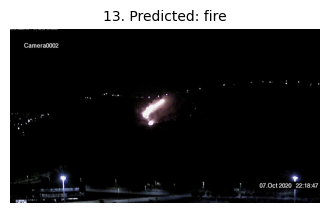

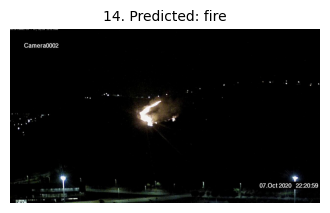

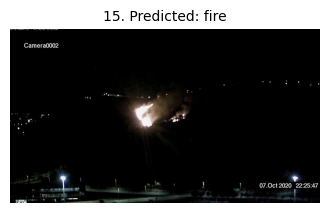

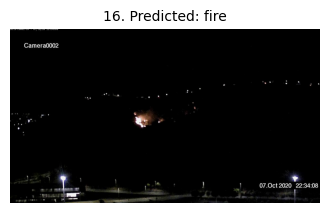

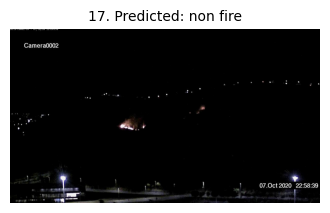

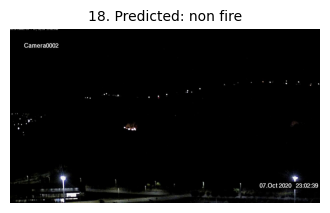

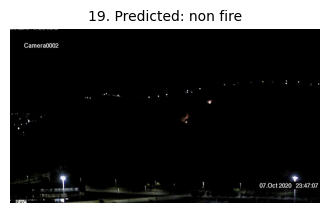

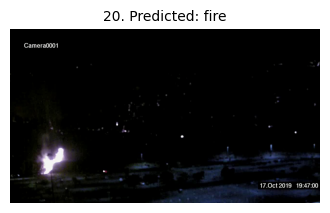

In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git

import clip
import torch
from PIL import Image
import os
from glob import glob
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

class_names = ["fire", "smoke", "non fire"]
text_tokens = clip.tokenize(class_names).to(device)

test_dir = "/content/dataset/images/test"
test_images = sorted(glob(f"{test_dir}/*.jpg"))

clip_preds = {}

for img_path in test_images[:20]:
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ text_features.T).squeeze(0)
        pred_label = class_names[similarity.argmax().item()]

    clip_preds[os.path.basename(img_path)] = pred_label

print("Displaying Images with CLIP Predictions (First 20):")

for i, (img_name, pred_label) in enumerate(clip_preds.items(), start=1):
    full_path = os.path.join(test_dir, img_name)
    image = Image.open(full_path).convert("RGB")

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{i:02d}. Predicted: {pred_label}", fontsize=10)
    plt.show()


Evaluate BLIP Caption Classification Accuracy

In [ ]:
!pip install -q transformers timm

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch, os
from glob import glob

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

test_dir = "/content/dataset/images/test"
test_images = sorted(glob(f"{test_dir}/*.jpg"))

def normalize_name(name):
    return os.path.basename(name).strip().lower()

captions = {}
for img_path in test_images:
    raw_image = Image.open(img_path).convert('RGB')
    inputs = processor(raw_image, return_tensors="pt").to(device)
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    captions[normalize_name(img_path)] = caption

def get_blip_label(caption):
    caption = caption.lower()
    if any(word in caption for word in ["fire", "flame", "burn", "blaze", "inferno", "burning"]):
        return "fire"
    elif any(word in caption for word in ["smoke", "smoky", "haze"]):
        return "smoke"
    else:
        return "non fire"

blip_preds = {img: get_blip_label(capt) for img, capt in captions.items()}

id2label = {0: "fire", 1: "smoke", 2: "non fire"}
label_dir = "/content/dataset/labels/test"
gt_labels = {}

for path in os.listdir(label_dir):
    if not path.endswith(".txt"):
        continue
    with open(os.path.join(label_dir, path)) as f:
        first_line = f.readline().strip()
        if first_line:
            class_id = int(first_line.split()[0])
            gt_labels[normalize_name(path.replace(".txt", ".jpg"))] = id2label[class_id]

blip_correct = 0
total = 0

for img in gt_labels:
    gt = gt_labels[img]
    pred = blip_preds.get(img, "unknown")
    if pred == gt:
        blip_correct += 1
    total += 1

blip_acc = blip_correct / total * 100
print(f"\nBLIP Classification Accuracy on {total} test images: {blip_acc:.2f}%")



BLIP Classification Accuracy on 900 test images: 48.22%
